<a href="https://colab.research.google.com/github/saks0106/ML_Frequent_Lookouts/blob/main/Bulldozer_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🚜 Predicting the Sale Price of Bulldozers using Machine Learning 🚜  

## 1. Problem Definition
For this dataset, the problem we're trying to solve, or better, the question we're trying to answer is,

How well can we predict the future sale price of a bulldozer, given its characteristics previous examples of how much similar bulldozers have been sold for?

## 2. Data
Looking at the dataset from Kaggle https://www.kaggle.com/c/bluebook-for-bulldozers/data , it's a time series problem.

In this case, it's historical sales data of bulldozers. Including things like, model type, size, sale date and more.

There are 2 datasets:

     1. TrainAndValid.csv - Historical bulldozer sales examples up to 2011 (close to 400,000 examples with 50+ different attributes, including SalePrice which is the target variable).
     
    
    2.Test.csv - Historical bulldozer sales examples from May 1 2012 to November 2012 (close to 12,000 examples but missing the SalePrice attribute, as this is what we'll be trying to predict).

## 3. Evaluation
For this problem, Kaggle has set the evaluation metric to being root mean squared log error (RMSLE). As with many regression evaluations, the goal will be to get this value as low as possible.

To see how well our model is doing, we'll calculate the RMSLE and then compare our results to others on the Kaggle leaderboard.

## 4. Features
Features are different parts of the data. During this step, we'll start finding out what the data is all about!

One of the most common ways to do this, is to create a data dictionary.

For this dataset, Kaggle provide a data dictionary which contains information about what each attribute of the dataset means. We can download this file directly from the Kaggle competition page or view it on Google Sheets.


First, we'll import the dataset and start exploring. Since we know the evaluation metric we're trying to minimise, our first goal will be building a baseline model and seeing how it stacks up against the competition.

## Importing the data and preparing it for modelling

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Model Evaluations
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, plot_roc_curve, roc_curve

#### We will download the dataset from kaggle link: https://www.kaggle.com/c/bluebook-for-bulldozers/data

In [ ]:
df = pd.read_csv('TrainAndValid.csv',low_memory=False)
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,11/16/2006 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,3/26/2004 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2/26/2004 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,5/19/2011 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,7/23/2009 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.info()
# If datatime dtype in df, the problem belongs to TimeSeries data but No parse_dates(check dtype of "saledate")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [ ]:
df.isnull().sum() # checking if any null values in the column

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

#### There are a lot of null values and also saledate column is of object type which needs to be handled

In [ ]:
# Let's check the columns
np.array(df.columns)

array(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter',
       'UsageBand', 'saledate', 'fiModelDesc', 'fiBaseModel',
       'fiSecondaryDesc', 'fiModelSeries', 'fiModelDescriptor',
       'ProductSize', 'fiProductClassDesc', 'state', 'ProductGroup',
       'ProductGroupDesc', 'Drive_System', 'Enclosure', 'Forks',
       'Pad_Type', 'Ride_Control', 'Stick', 'Transmission',
       'Turbocharged', 'Blade_Extension', 'Blade_Width', 'Enclosure_Type',
       'Engine_Horsepower', 'Hydraulics', 'Pushblock', 'Ripper',
       'Scarifier', 'Tip_Control', 'Tire_Size', 'Coupler',
       'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting',
       'Blade_Type', 'Travel_Controls', 'Differential_Type',
       'Steering_Controls'], dtype=object)

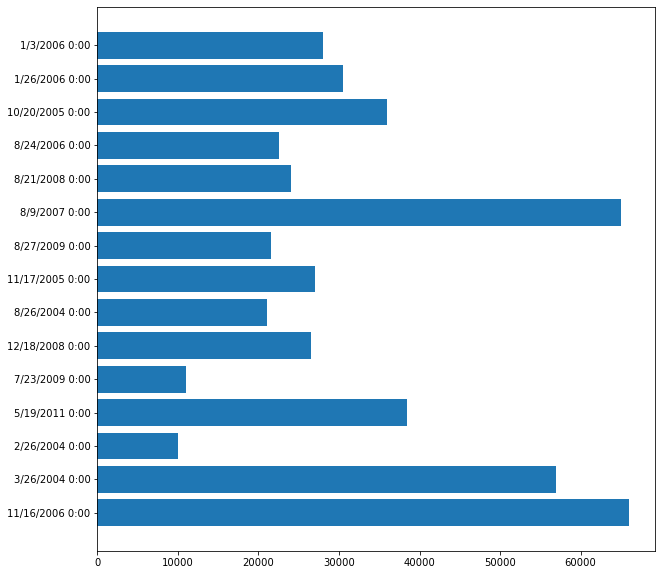

In [ ]:
#plotting bar graph
fig, ax = plt.subplots(figsize=(10,10))
ax.barh(df['saledate'][:15],df['SalePrice'][:15]); # plotting a barh graph
#ax.scatter(df['saledate'],df['SalePrice'])

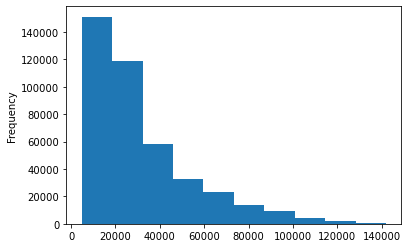

In [ ]:
df['SalePrice'].plot.hist();
# saleprice is positively skewwed ie most values lay in range between 20k to 40 along with few outliers

In [ ]:
#Date is important therefore we will parse the the saledate column into datetime dtype
df.saledate.dtype # saledate is object type.

dtype('O')

In [ ]:
#Let's reimport the csv file and parse saledate field
df= pd.read_csv('TrainAndValid.csv',parse_dates=['saledate'],low_memory=False) # low_memory = False means all computer memory necessary
#parse_dates will convert object to datetime

In [ ]:
df.info() # saledate column has been changed to datetime

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalesID                   412698 non-null  int64         
 1   SalePrice                 412698 non-null  float64       
 2   MachineID                 412698 non-null  int64         
 3   ModelID                   412698 non-null  int64         
 4   datasource                412698 non-null  int64         
 5   auctioneerID              392562 non-null  float64       
 6   YearMade                  412698 non-null  int64         
 7   MachineHoursCurrentMeter  147504 non-null  float64       
 8   UsageBand                 73670 non-null   object        
 9   saledate                  412698 non-null  datetime64[ns]
 10  fiModelDesc               412698 non-null  object        
 11  fiBaseModel               412698 non-null  object        
 12  fi

In [ ]:
df.saledate.dtype

dtype('<M8[ns]')

In [ ]:
np.dtype('datetime64[ns]') == np.dtype('<M8[ns]') # same as datetime dtype

True

In [ ]:
df['saledate'][:5]

0   2006-11-16
1   2004-03-26
2   2004-02-26
3   2011-05-19
4   2009-07-23
Name: saledate, dtype: datetime64[ns]

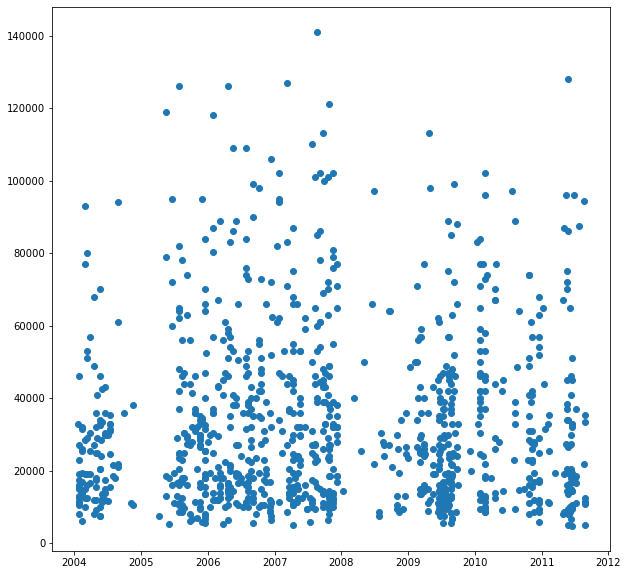

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(df['saledate'][:1000],df['SalePrice'][:1000]);
# for different saledate, we are getting different prices for bulldozers

In [ ]:
#Let's Transpose the df data ie turn rows to columns and vice versa
df.head().T

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000.0,57000.0,10000.0,38500.0,11000.0
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3.0,3.0,3.0,3.0,3.0
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68.0,4640.0,2838.0,3486.0,722.0
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


#### Sorting datetime is important as we're working on a time series problem and trying to predict future examples given past examples, it makes sense to sort our data by date.


In [ ]:
df.sort_values(by=['saledate'],axis=0,ascending=True,inplace=True)

In [ ]:
df.saledate.head(20)

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
54653    1989-01-31
81383    1989-01-31
204924   1989-01-31
135376   1989-01-31
113390   1989-01-31
113394   1989-01-31
116419   1989-01-31
32138    1989-01-31
127610   1989-01-31
76171    1989-01-31
127000   1989-01-31
128130   1989-01-31
127626   1989-01-31
55455    1989-01-31
55454    1989-01-31
Name: saledate, dtype: datetime64[ns]

In [ ]:
#let's check if values are sorted based on saledate
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
205615,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,1989-01-17,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
274835,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
141296,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
212552,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
62755,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,Lever,NaN,NaN


In [ ]:
#Let's make a copy so as to revert back is needed. From now on we will use dft
dft = df.copy()

In [ ]:
dft.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
205615,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,1989-01-17,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
274835,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
141296,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
212552,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
62755,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,Lever,NaN,NaN


In [ ]:
#splitting the datatime parameters
dft.saledate[:1]

205615   1989-01-17
Name: saledate, dtype: datetime64[ns]

#### Saledate has 3 components year, month, day. We need to split it into individual component and then delete the saledate column

In [ ]:
#to get year component
dft.saledate.dt.year[:1]

205615    1989
Name: saledate, dtype: int64

In [ ]:
#to get day component
dft.saledate.dt.day[:1]

205615    17
Name: saledate, dtype: int64

In [ ]:
#adding year,month,day,dayofweek,dayofyear to dft and remove saledate column
dft['saleyear'] = dft.saledate.dt.year
dft['salemonth'] = dft.saledate.dt.month
dft['saleday']= dft.saledate.dt.day
dft['saledayofweek']= dft.saledate.dt.day_of_week
dft['saledayofyear']= dft.saledate.dt.day_of_year

In [ ]:
dft.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,1989-01-17 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00


In [ ]:
#dropping the saledate component has we have already splitted it into individual component
dft.drop('saledate',axis=1,inplace=True)

In [ ]:
dft.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,A66,D7G,A62,D3B


In [ ]:
dft.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleyear,salemonth,saleday,saledayofweek,saledayofyear
205615,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,TD20,...,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,17,1,17
274835,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,A66,...,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1,31
141296,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,D7G,...,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,31,1,31
212552,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,A62,...,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1,31
62755,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,D3B,...,None or Unspecified,PAT,Lever,NaN,NaN,1989,1,31,1,31


In [ ]:
#checking different states value counts
dft.state.value_counts()

Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Montana            1336
Iowa               1336
Oklahoma           1326
Nebraska            866
West Virginia   

In [ ]:
# check how many null value exist
dft.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension             386715
Blade_Width         

In [ ]:
dft.info()# int,float,object datatypes are there
#main goal is to convert object(str) into categorical values because categorical values can be converted into nums via OHE

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   fiModelDesc               412698 non-null  object 
 10  fiBaseModel               412698 non-null  object 
 11  fiSecondaryDesc           271971 non-null  object 
 12  fiModelSeries             58667 non-null   object 
 13  fiModelDescriptor         74816 non-nul

In [ ]:
pd.api.types.is_string_dtype(dft['UsageBand'])# object is string type or not

True

### For Checking and converting datatypes we'll use  Pandas types API:

https://pandas.pydata.org/pandas-docs/stable/reference/general_utility_functions.html#data-types-related-functionality

In [ ]:
#Let's check which all columns have object type
string_columns = []
for column,content in dft.items():
    if pd.api.types.is_string_dtype(content):
        string_columns.append(column)
print(string_columns)

['UsageBand', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries', 'fiModelDescriptor', 'ProductSize', 'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc', 'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control', 'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension', 'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size', 'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow', 'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb', 'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls', 'Differential_Type', 'Steering_Controls']


#### Many columns have object type which we have to convert to categorical

In [ ]:
#Let's convert all above columns into categorical
for column,content in dft.items():
    if pd.api.types.is_string_dtype(content):
        dft[column]= content.astype('category').cat.as_ordered()# category as ascending
                                                #use .as_ordered if you want to sort inside values else .categorical
                                                #.cat is same like .dt used before for datetime

In [ ]:
dft.info() # we have no object datatype

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor       

### Object value are now handled and converted into categorical

In [ ]:
#checking the state column
dft.state.cat.categories

Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Unspecified', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'Washington DC', 'West Virginia', 'Wisconsin',
       'Wyoming'],
      dtype='object')

In [ ]:
dft.state.value_counts()

Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Montana            1336
Iowa               1336
Oklahoma           1326
Nebraska            866
West Virginia   

In [ ]:
dft.state.cat.codes# .codes tells what individual is assigned to each state

205615    43
274835     8
141296     8
212552     8
62755      8
          ..
410879     4
412476     4
411927     4
407124     4
409203     4
Length: 412698, dtype: int8

In [ ]:
dft.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension             386715
Blade_Width         

In [ ]:
len(dft)

412698

In [ ]:
# #Save preprocessed data
# # Export current tmp dataframe
# df_tmp.to_csv("train_tmp.csv",
#               index=False)



# # Import preprocessed data
# df_tmp = pd.read_csv("train_tmp.csv",
#                      low_memory=False)
# df_tmp.head().T

### Fill missing values - Fill numerical missing values first


In [ ]:
for label,content in dft.items():
    if pd.api.types.is_numeric_dtype(content): # int+float
        print(label)


SalesID
SalePrice
MachineID
ModelID
datasource
auctioneerID
YearMade
MachineHoursCurrentMeter
saleyear
salemonth
saleday
saledayofweek
saledayofyear


#### Inside the numeric columns, which columns have null values

In [ ]:
for label, content in dft.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

auctioneerID
MachineHoursCurrentMeter


In [ ]:
# These 2 need to be filled with certain values
# auctioneerID
# MachineHoursCurrentMeter
# median is robust ie provides better results than mean

#### Checking mean, median and mode for our 2 columns

In [ ]:
dft['auctioneerID'].mean(), dft['auctioneerID'].median(), dft['auctioneerID'].mode()

(6.58526805956766,
 2.0,
 0    1.0
 dtype: float64)

In [ ]:
dft['MachineHoursCurrentMeter'].mean(), dft['MachineHoursCurrentMeter'].median(), dft['MachineHoursCurrentMeter'].mode()

(3522.988285063456,
 0.0,
 0    0.0
 dtype: float64)

#### Filling above 2 missing rows with its median as data is huge and mean is influenced by outliers

In [ ]:
for label, content in dft.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            #fill missing value with median
            dft[label]= content.fillna(content.median())

In [ ]:
dft

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleyear,salemonth,saleday,saledayofweek,saledayofyear
205615,1646770,9500.0,1126363,8434,132,18.0,1974,0.0,NaN,TD20,...,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,17,1,17
274835,1821514,14000.0,1194089,10150,132,99.0,1980,0.0,NaN,A66,...,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1,31
141296,1505138,50000.0,1473654,4139,132,99.0,1978,0.0,NaN,D7G,...,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,31,1,31
212552,1671174,16000.0,1327630,8591,132,99.0,1980,0.0,NaN,A62,...,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1,31
62755,1329056,22000.0,1336053,4089,132,99.0,1984,0.0,NaN,D3B,...,None or Unspecified,PAT,Lever,NaN,NaN,1989,1,31,1,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410879,6302984,16000.0,1915521,5266,149,99.0,2001,0.0,NaN,D38E,...,None or Unspecified,PAT,None or Unspecified,NaN,NaN,2012,4,28,5,119
412476,6324811,6000.0,1919104,19330,149,99.0,2004,0.0,NaN,2064,...,NaN,NaN,NaN,NaN,NaN,2012,4,28,5,119
411927,6313029,16000.0,1918416,17244,149,99.0,2004,0.0,NaN,337G,...,NaN,NaN,NaN,NaN,NaN,2012,4,28,5,119
407124,6266251,55000.0,509560,3357,149,99.0,1993,0.0,NaN,12G,...,NaN,NaN,NaN,NaN,NaN,2012,4,28,5,119


In [ ]:
dft.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                     0
YearMade                         0
MachineHoursCurrentMeter         0
UsageBand                   339028
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension             386715
Blade_Width         

In [ ]:
#All numeric data has non null values
#let's check all non numeric data with null values

for label, content in dft.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


### Turn categorical variables(objects) into numbers as well as fill missing values

In [ ]:
for label, content in dft.items():
    if not pd.api.types.is_numeric_dtype(content):
        # Add binary column to indicate whether sample had missing value
        # Turn categories into numbers and add +1
        dft[label] = pd.Categorical(content).codes+1 # +1 because if null value found, .codes returns -1.
                                                        # by adding +1 to -1 = 0

In [ ]:
dft

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleyear,salemonth,saleday,saledayofweek,saledayofyear
205615,1646770,9500.0,1126363,8434,132,18.0,1974,0.0,0,4593,...,1,8,6,0,0,1989,1,17,1,17
274835,1821514,14000.0,1194089,10150,132,99.0,1980,0.0,0,1820,...,0,0,0,4,2,1989,1,31,1,31
141296,1505138,50000.0,1473654,4139,132,99.0,1978,0.0,0,2348,...,1,8,6,0,0,1989,1,31,1,31
212552,1671174,16000.0,1327630,8591,132,99.0,1980,0.0,0,1819,...,0,0,0,4,2,1989,1,31,1,31
62755,1329056,22000.0,1336053,4089,132,99.0,1984,0.0,0,2119,...,1,6,5,0,0,1989,1,31,1,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410879,6302984,16000.0,1915521,5266,149,99.0,2001,0.0,0,2101,...,1,6,6,0,0,2012,4,28,5,119
412476,6324811,6000.0,1919104,19330,149,99.0,2004,0.0,0,240,...,0,0,0,0,0,2012,4,28,5,119
411927,6313029,16000.0,1918416,17244,149,99.0,2004,0.0,0,627,...,0,0,0,0,0,2012,4,28,5,119
407124,6266251,55000.0,509560,3357,149,99.0,1993,0.0,0,83,...,0,0,0,0,0,2012,4,28,5,119


In [ ]:
pd.Categorical(dft["state"]).codes+1, pd.Categorical(dft["state"]).codes

(array([44,  9,  9, ...,  5,  5,  5], dtype=int8),
 array([43,  8,  8, ...,  4,  4,  4], dtype=int8))

### Addding .codes to Categorical value will convert null to int values

In [ ]:
pd.Categorical(dft["UsageBand"]).codes+1, pd.Categorical(dft["UsageBand"]).codes

(array([1, 1, 1, ..., 1, 1, 1], dtype=int8),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int8))

In [ ]:
#Checking if any null values present

In [ ]:
dft.isna().sum()

SalesID                     0
SalePrice                   0
MachineID                   0
ModelID                     0
datasource                  0
auctioneerID                0
YearMade                    0
MachineHoursCurrentMeter    0
UsageBand                   0
fiModelDesc                 0
fiBaseModel                 0
fiSecondaryDesc             0
fiModelSeries               0
fiModelDescriptor           0
ProductSize                 0
fiProductClassDesc          0
state                       0
ProductGroup                0
ProductGroupDesc            0
Drive_System                0
Enclosure                   0
Forks                       0
Pad_Type                    0
Ride_Control                0
Stick                       0
Transmission                0
Turbocharged                0
Blade_Extension             0
Blade_Width                 0
Enclosure_Type              0
Engine_Horsepower           0
Hydraulics                  0
Pushblock                   0
Ripper    

In [ ]:
dft.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              412698 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  412698 non-null  float64
 8   UsageBand                 412698 non-null  int8   
 9   fiModelDesc               412698 non-null  int16  
 10  fiBaseModel               412698 non-null  int16  
 11  fiSecondaryDesc           412698 non-null  int16  
 12  fiModelSeries             412698 non-null  int8   
 13  fiModelDescriptor         412698 non-nu

### Now that all of data is numeric as well as our dataframe has no missing values, we should be able to build a machine learning model

### Now all of our data is numeric and there are no missing values, we should be able to build a machine learning model! Let's try various types of Regression Models and find a best or two which works for our dataset.

In [ ]:
dft

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleyear,salemonth,saleday,saledayofweek,saledayofyear
205615,1646770,9500.0,1126363,8434,132,18.0,1974,0.0,0,4593,...,1,8,6,0,0,1989,1,17,1,17
274835,1821514,14000.0,1194089,10150,132,99.0,1980,0.0,0,1820,...,0,0,0,4,2,1989,1,31,1,31
141296,1505138,50000.0,1473654,4139,132,99.0,1978,0.0,0,2348,...,1,8,6,0,0,1989,1,31,1,31
212552,1671174,16000.0,1327630,8591,132,99.0,1980,0.0,0,1819,...,0,0,0,4,2,1989,1,31,1,31
62755,1329056,22000.0,1336053,4089,132,99.0,1984,0.0,0,2119,...,1,6,5,0,0,1989,1,31,1,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410879,6302984,16000.0,1915521,5266,149,99.0,2001,0.0,0,2101,...,1,6,6,0,0,2012,4,28,5,119
412476,6324811,6000.0,1919104,19330,149,99.0,2004,0.0,0,240,...,0,0,0,0,0,2012,4,28,5,119
411927,6313029,16000.0,1918416,17244,149,99.0,2004,0.0,0,627,...,0,0,0,0,0,2012,4,28,5,119
407124,6266251,55000.0,509560,3357,149,99.0,1993,0.0,0,83,...,0,0,0,0,0,2012,4,28,5,119


In [ ]:
dft.describe()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleyear,salemonth,saleday,saledayofweek,saledayofyear
count,4.126980e+05,412698.000000,4.126980e+05,412698.000000,412698.000000,412698.000000,412698.000000,4.126980e+05,412698.000000,412698.000000,...,412698.00000,412698.000000,412698.000000,412698.000000,412698.000000,412698.000000,412698.000000,412698.000000,412698.000000,412698.000000
mean,2.011161e+06,31215.181414,1.230061e+06,6947.201828,135.169361,6.361548,1899.049637,1.259165e+03,0.413486,1697.462231,...,0.19562,1.273566,1.126720,0.684513,0.345611,2004.317382,6.300268,16.152894,2.594338,176.784094
std,1.080068e+06,23141.743695,4.539533e+05,6280.824982,9.646749,16.763713,292.190243,1.633077e+04,0.941340,1281.860399,...,0.39680,2.644549,2.301722,1.503114,0.756225,5.821090,3.437276,8.429510,1.417971,103.910718
min,1.139246e+06,4750.000000,0.000000e+00,28.000000,121.000000,0.000000,1000.000000,0.000000e+00,0.000000,1.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,1989.000000,1.000000,1.000000,0.000000,1.000000
25%,1.421898e+06,14500.000000,1.088593e+06,3261.000000,132.000000,1.000000,1985.000000,0.000000e+00,0.000000,640.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,2000.000000,3.000000,9.000000,2.000000,82.000000
50%,1.645852e+06,24000.000000,1.284397e+06,4605.000000,132.000000,2.000000,1995.000000,0.000000e+00,0.000000,1413.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,2006.000000,6.000000,16.000000,3.000000,165.000000
75%,2.261012e+06,40000.000000,1.478079e+06,8899.000000,136.000000,4.000000,2001.000000,0.000000e+00,0.000000,2316.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,2009.000000,9.000000,23.000000,3.000000,270.000000
max,6.333349e+06,142000.000000,2.486330e+06,37198.000000,173.000000,99.000000,2014.000000,2.483300e+06,3.000000,5059.000000,...,2.00000,10.000000,7.000000,4.000000,5.000000,2012.000000,12.000000,31.000000,6.000000,365.000000


In [ ]:
dft.corr()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleyear,salemonth,saleday,saledayofweek,saledayofyear
SalesID,1.000000,0.023119,0.310149,0.147883,0.768909,-0.007111,0.005316,0.027935,0.142339,0.078597,...,-0.029527,-0.030595,-0.037630,-0.006764,-0.006464,0.465565,0.008000,0.029720,-0.109902,0.010487
SalePrice,0.023119,1.000000,-0.216841,-0.038063,0.021708,-0.046357,0.154389,0.017921,0.073002,0.006936,...,0.112081,0.134685,0.081721,0.117448,0.119782,0.043393,-0.033374,-0.000527,-0.056015,-0.033482
MachineID,0.310149,-0.216841,1.000000,0.165140,0.375914,-0.003944,-0.052118,0.006746,0.050644,0.077816,...,-0.066139,-0.083579,-0.052466,0.012808,0.005901,0.083661,0.005383,0.003439,-0.026031,0.005633
ModelID,0.147883,-0.038063,0.165140,1.000000,0.097704,-0.019525,-0.045511,0.007880,0.138433,0.200001,...,-0.114233,-0.124945,-0.108416,-0.043292,-0.045272,0.144706,-0.002906,0.007134,-0.002707,-0.002308
datasource,0.768909,0.021708,0.375914,0.097704,1.000000,-0.020133,0.070933,0.039851,0.243119,0.024115,...,-0.011552,-0.010418,-0.021571,0.000681,-0.000023,0.354394,0.002488,0.005641,-0.124246,0.002675
auctioneerID,-0.007111,-0.046357,-0.003944,-0.019525,-0.020133,1.000000,-0.017114,0.008788,-0.005523,-0.012759,...,0.015338,0.012090,0.019088,-0.002969,-0.002580,-0.068789,0.012736,-0.015286,0.094230,0.011183
YearMade,0.005316,0.154389,-0.052118,-0.045511,0.070933,-0.017114,1.000000,-0.011555,0.048129,-0.130495,...,0.012270,0.016224,0.007994,-0.002494,-0.001614,-0.042783,0.017667,-0.011406,-0.045169,0.016959
MachineHoursCurrentMeter,0.027935,0.017921,0.006746,0.007880,0.039851,0.008788,-0.011555,1.000000,0.120932,0.004097,...,-0.001183,-0.001416,-0.003727,0.011910,0.011415,0.065204,-0.014689,0.000408,0.013436,-0.015004
UsageBand,0.142339,0.073002,0.050644,0.138433,0.243119,-0.005523,0.048129,0.120932,1.000000,0.039098,...,-0.017798,-0.022533,-0.027680,-0.021918,-0.021450,0.336189,0.007125,0.012519,-0.015624,0.007910
fiModelDesc,0.078597,0.006936,0.077816,0.200001,0.024115,-0.012759,-0.130495,0.004097,0.039098,1.000000,...,0.127169,0.134050,0.122504,0.119638,0.120205,0.043823,-0.014073,0.002124,-0.005322,-0.013854


### From the above corr() , we'll use scatter plot for fiModelSeries vs Hydraulics_Flow on SalePrice uisng pyplot method

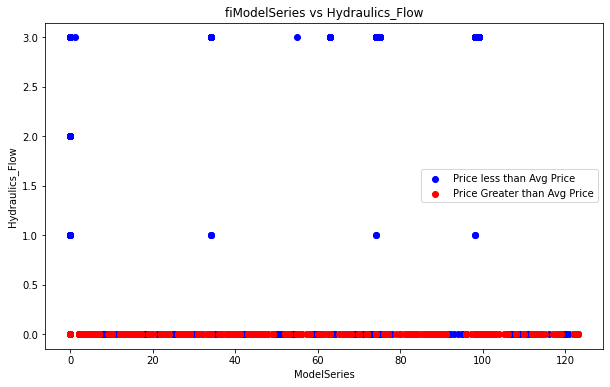

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(dft.fiModelSeries[dft.SalePrice < np.mean(dft['SalePrice'])],
            dft.Hydraulics_Flow[dft.SalePrice < np.mean(dft['SalePrice'])],c='blue')


plt.scatter(dft.fiModelSeries[dft.SalePrice > np.mean(dft['SalePrice'])],
            dft.Hydraulics_Flow[dft.SalePrice > np.mean(dft['SalePrice'])],c='red')

plt.title("fiModelSeries vs Hydraulics_Flow")
plt.xlabel("ModelSeries")
plt.ylabel("Hydraulics_Flow")
plt.legend(["Price less than Avg Price",'Price Greater than Avg Price']);

<AxesSubplot:ylabel='Frequency'>

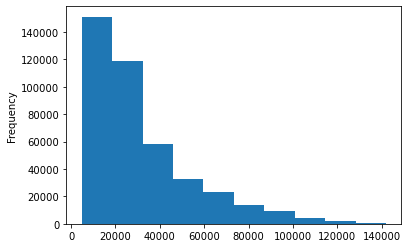

In [ ]:
dft['SalePrice'].plot.hist()

### Plotting a heat map to find correlation between tables

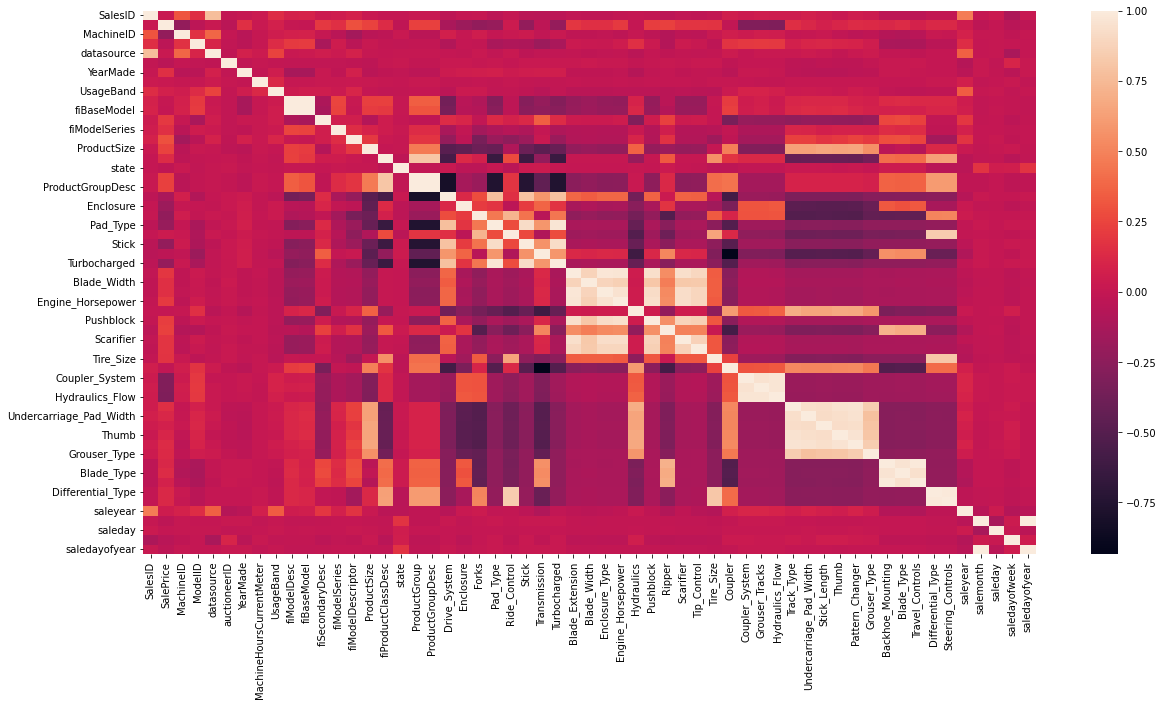

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.heatmap(dft.corr(),annot=False)# can also add linewidths = 1,fmt = ".2f",cmap='YlGnBu'


In [ ]:
X = dft.drop("SalePrice",axis=1)
y = dft['SalePrice']

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

In [ ]:
len(X_train),len(y_train), len(X_test), len(y_test)

(330158, 330158, 82540, 82540)

# 5.Modelling

#### We know the evaluation metric we're heading towards. We could spend more time doing exploratory data analysis (EDA), finding more out about the data ourselves but what we'll do instead is use a machine learning model to help us do EDA. Also, one of the biggest goals of starting any new machine learning project is reducing the time between experiments.

In [ ]:
#Checking the values count for different years
dft['saleyear'], dft.saleyear.value_counts()

(205615    1989
 274835    1989
 141296    1989
 212552    1989
 62755     1989
           ... 
 410879    2012
 412476    2012
 411927    2012
 407124    2012
 409203    2012
 Name: saleyear, Length: 412698, dtype: int64,
 2009    43849
 2008    39767
 2011    35197
 2010    33390
 2007    32208
 2006    21685
 2005    20463
 2004    19879
 2001    17594
 2000    17415
 2002    17246
 2003    15254
 1998    13046
 1999    12793
 2012    11573
 1997     9785
 1996     8829
 1995     8530
 1994     7929
 1993     6303
 1992     5519
 1991     5109
 1989     4806
 1990     4529
 Name: saleyear, dtype: int64)

## The Following Models used for Regression Problem are inspired from below:
https://towardsdatascience.com/7-of-the-most-commonly-used-regression-algorithms-and-how-to-choose-the-right-one-fc3c8890f9e3#fc86

# 5.1 Random Forest Regressor

#### By merging several uncorrelated Decision Trees, often a significant improvement of the model accuracy can be achieved. This method is called Random Forest. The trees are influenced by certain random processes (randomization) as they grow. The final model reflects an averaging of the trees.  As the tree grows, a selection of a subset of the features takes place at each node. These serve as criteria for splitting the dataset. The target value is then determined for each Decision Tree individually. The averaging of these predictions represents the prediction of the Random Forest. The Random Forest has a number of hyperparameters. The most crucial one, besides the maximum depth of the trees max_depth, is the number of decision trees n_estimators. By default, the Mean Square Error (MSE) is used as criterion for splitting the dataset as the trees grow.

In [ ]:
# Instantiate RandomForestRegressor model
from sklearn.ensemble import RandomForestRegressor
# define used regressor
regressor=RandomForestRegressor(n_estimators=10,
                             max_depth=10,
                             random_state=42
                            )

# Fit the model
regressor.fit(X_train, y_train)
# Score the model- evaluation based on same set of data. split will happen later
regressor.score(X_train, y_train)

0.8191649949485967

In [ ]:
regressor.score(X_test, y_test)

0.8134436207702724

In [ ]:
y_preds = regressor.predict(X_test)
y_preds

array([10420.10304672,  7830.87791939, 13231.10334227, ...,
       56144.58735429, 47913.99101768, 21230.99761612])

In [ ]:
np.array(y_test)

array([10000.,  9000.,  7500., ..., 59000., 34000., 21000.])

In [ ]:
regressor.score(X_test,y_test)

0.8134436207702724

# 5.2 Polynomial Regression

#### Polynomial regression allows control of model complexity via the polynomial degree. Parameters that are set by the user before the algorithm is executed are called hyperparameters. Most regression methods include several hyperparameters, which significantly influence the accuracy of the resulting regression model.

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline


# define the pipeline and train model
poly = Pipeline([('poly', PolynomialFeatures(degree=2)),
                  ('linear', LinearRegression(fit_intercept=False))])

poly.fit(X_train, y_train)

# print out regression coefficients
print(poly.named_steps['linear'].coef_)
print(poly.named_steps['linear'].intercept_)
print(f" Score on Test Data is: {poly.score(X_test, y_test)}")

MemoryError: Unable to allocate 4.07 GiB for an array with shape (330158, 1653) and data type float64

# 5.3 Support Vector Regression

### The functionality of the Support Vector Regression (SVR) is based on the Support Vector Machine (SVM)

In [ ]:
from sklearn import svm
svr = svm.SVR()
svr.fit(X_train, y_train)
svr.score(X_test,y_test)




# 5.4 Linear Models

In [ ]:
from sklearn import linear_model
reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)
reg.score(X_test,y_test)

In [ ]:
#trying ridge and svm 1st before using RandomForest
from sklearn.linear_model import Ridge
np.random.seed(42)
#split the data as all values are numerical and no missing data

ridge = Ridge()
#svm = svm.SVR()
ridge.fit(X_train,y_train)
#svm.fit(X_train,y_train)
ridge.score(X_test,y_test)
#svm.score(X_test,y_test)

In [ ]:
from sklearn import linear_model
reg = linear_model.Lasso(alpha=0.1)
reg.fit(X_train,y_train)

reg.score(X_test,y_test)

In [ ]:
from sklearn import linear_model
reg = linear_model.LassoLars(alpha=.1, normalize=False)
reg.fit(X_train,y_train)

reg.score(X_test,y_test)

In [ ]:
from sklearn import linear_model
reg = linear_model.BayesianRidge()
reg.fit(X_train,y_train)

reg.score(X_test,y_test)

## As from the above models score, Random Forest Regression gives us results with minimum error and high prediction score. We could compare the other models but other models do not yeild satisfying results. Therefore, we'll Evaluate Random Forest Regressor Model and try to improve the score even further by Hyperparameter tuning

In [ ]:
y_preds = regressor.predict(X_test)
y_preds

array([10420.10304672,  7830.87791939, 13231.10334227, ...,
       56144.58735429, 47913.99101768, 21230.99761612])

# Building an evaluation function

Evaluation metric for this competition is the Root Mean Squared Log Error(RMSLE) between the actual and predicted auction price. Goal of most Regression problem is to minimize this error


In [ ]:
# Create evaluation function (the competition uses RMSLE)
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error, mean_squared_log_error
# think of mae as 10 rupees off# squared, log- think as 10% off

def rmsle(y_test, y_preds):
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

def show_scores(model):
    train_preds = regressor.predict(X_train)
    val_preds = regressor.predict(X_test)

    evaluation = {
                  "Train MAE": mean_absolute_error(y_train, train_preds),
                  "Test MAE": mean_absolute_error(y_test, val_preds),
                  "Train RMSLE": rmsle(y_train, train_preds),
                  "Test RMSLE": rmsle(y_test, val_preds),
                  "Train MSE": mean_squared_error(y_train, train_preds),
                  "Test MSE": mean_squared_error(y_test, val_preds),
                  "Train R^2": r2_score(y_train, train_preds),
                  "Test R^2": r2_score(y_test, val_preds)
    }

    for key, value in evaluation.items():
        #print(key,value)
         print(f"The {key} value is {np.round(value,2)} % ")



In [ ]:
show_scores(regressor)

The Train MAE value is 6525.5 % 
The Test MAE value is 6645.05 % 
The Train RMSLE value is 0.29 % 
The Test RMSLE value is 0.3 % 
The Train MSE value is 96690036.2 % 
The Test MSE value is 100544022.35 % 
The Train R^2 value is 0.82 % 
The Test R^2 value is 0.81 % 


### Hyperparameter tuning with RandomizedSearchCV- trying to improve the above score

In [ ]:
%%time
from sklearn.model_selection import RandomizedSearchCV

# Different RandomForestRegressor hyperparameters
rf_grid = {"n_estimators": np.arange(10, 100, 10),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2),
           "max_features": [0.5, 1, "sqrt", "auto"],
           "max_samples": [10000]}



# Instantiate RandomizedSearchCV model
rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1,
                                                    random_state=42),
                              param_distributions=rf_grid,
                              n_iter=2, # higher the value of n_iteration, more time for result. 2 different random
                                        # combination from rd_grid, assign to Random forest regressor and then fit
                                        # 100 would be a better option if more time and good processing speed
                              cv=5, # total 5*2 = 10 fits
                              verbose=True)

# Fit the RandomizedSearchCV model
rs_model.fit(X_train, y_train)


In [ ]:
# Find the best model hyperparameters from above
rs_model.best_params_

In [ ]:
# Evaluate the RandomizedSearch model- model has worsened because of 2 iterations
show_scores(rs_model)

# Train a model with the best hyperparamters

Note: These were found after 100 iterations of RandomizedSearchCV.


In [ ]:
%%time

# Most ideal hyperparamters- found out by dnaiel
ideal_model = RandomForestRegressor(n_estimators=40, # 40 model rather than 100
                                    min_samples_leaf=1,
                                    min_samples_split=14,
                                    max_features=0.5,
                                    n_jobs=-1,
                                    max_samples=None,
                                    random_state=42) # random state so our results are reproducible

# Fit the ideal model
ideal_model.fit(X_train, y_train)

Wall time: 1min 3s


RandomForestRegressor(max_features=0.5, min_samples_split=14, n_estimators=40,
                      n_jobs=-1, random_state=42)

In [ ]:
# Scores on rs_model (only trained on ~10,000 examples)
show_scores(ideal_model)

The Train MAE value is 6525.5 % 
The Test MAE value is 6645.05 % 
The Train RMSLE value is 0.29 % 
The Test RMSLE value is 0.3 % 
The Train MSE value is 96690036.2 % 
The Test MSE value is 100544022.35 % 
The Train R^2 value is 0.82 % 
The Test R^2 value is 0.81 % 


In [ ]:
#Before our ideal model
show_scores(regressor)

The Train MAE value is 6525.5 % 
The Test MAE value is 6645.05 % 
The Train RMSLE value is 0.29 % 
The Test RMSLE value is 0.3 % 
The Train MSE value is 96690036.2 % 
The Test MSE value is 100544022.35 % 
The Train R^2 value is 0.82 % 
The Test R^2 value is 0.81 % 


## Not much has changed between our old regressor and Hyperparameter Tuned Model

# Make predictions on test data

In [ ]:
# Import the test data
df_test = pd.read_csv("Test.csv",
                      low_memory=False,
                      parse_dates=["saledate"])

df_test.head() # it doesn't have price column as we need to predict it



,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


In [ ]:
test_preds = ideal_model.predict(df_test)

C:\Users\acer\Desktop\sample_project_1\env\lib\site-packages\sklearn\base.py:488: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- saledate
Feature names seen at fit time, yet now missing:
- saleday
- saledayofweek
- saledayofyear
- salemonth
- saleyear

  warnings.warn(message, FutureWarning)


ValueError: could not convert string to float: 'Low'

In [ ]:
df_test.info(), df_test.columns # no of columns don't match with training set

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12457 entries, 0 to 12456
Data columns (total 52 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   SalesID                   12457 non-null  int64         
 1   MachineID                 12457 non-null  int64         
 2   ModelID                   12457 non-null  int64         
 3   datasource                12457 non-null  int64         
 4   auctioneerID              12457 non-null  int64         
 5   YearMade                  12457 non-null  int64         
 6   MachineHoursCurrentMeter  2129 non-null   float64       
 7   UsageBand                 1834 non-null   object        
 8   saledate                  12457 non-null  datetime64[ns]
 9   fiModelDesc               12457 non-null  object        
 10  fiBaseModel               12457 non-null  object        
 11  fiSecondaryDesc           8482 non-null   object        
 12  fiModelSeries     

(None,
 Index(['SalesID', 'MachineID', 'ModelID', 'datasource', 'auctioneerID',
        'YearMade', 'MachineHoursCurrentMeter', 'UsageBand', 'saledate',
        'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries',
        'fiModelDescriptor', 'ProductSize', 'fiProductClassDesc', 'state',
        'ProductGroup', 'ProductGroupDesc', 'Drive_System', 'Enclosure',
        'Forks', 'Pad_Type', 'Ride_Control', 'Stick', 'Transmission',
        'Turbocharged', 'Blade_Extension', 'Blade_Width', 'Enclosure_Type',
        'Engine_Horsepower', 'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier',
        'Tip_Control', 'Tire_Size', 'Coupler', 'Coupler_System',
        'Grouser_Tracks', 'Hydraulics_Flow', 'Track_Type',
        'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb', 'Pattern_Changer',
        'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls',
        'Differential_Type', 'Steering_Controls'],
       dtype='object'))

### Preprocessing the data (getting the test dataset in the same format as our training dataset)

In [ ]:
dft.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries',
       'fiModelDescriptor', 'ProductSize', 'fiProductClassDesc', 'state',
       'ProductGroup', 'ProductGroupDesc', 'Drive_System', 'Enclosure',
       'Forks', 'Pad_Type', 'Ride_Control', 'Stick', 'Transmission',
       'Turbocharged', 'Blade_Extension', 'Blade_Width', 'Enclosure_Type',
       'Engine_Horsepower', 'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier',
       'Tip_Control', 'Tire_Size', 'Coupler', 'Coupler_System',
       'Grouser_Tracks', 'Hydraulics_Flow', 'Track_Type',
       'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb', 'Pattern_Changer',
       'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls',
       'Differential_Type', 'Steering_Controls', 'saleyear', 'salemonth',
       'saleday', 'saledayofweek', 'saledayofyear'],
      dtype

In [ ]:
df_test["saleyear"] = df_test.saledate.dt.year
df_test["salemonth"] = df_test.saledate.dt.month
df_test["saleday"] = df_test.saledate.dt.day
df_test["saledayofweek"] = df_test.saledate.dt.dayofweek
df_test["saledayofyear"] = df_test.saledate.dt.dayofyear

df_test.drop("saledate", axis=1, inplace=True)

# Fill the numeric rows with median
for label, content in df_test.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            # Fill missing numeric values with median
            df_test[label] = content.fillna(content.median())

    # Filled categorical missing data and turn categories into numbers
    if not pd.api.types.is_numeric_dtype(content):
        # We add +1 to the category code because pandas encodes missing categories as -1
        df_test[label] = pd.Categorical(content).codes+1



In [ ]:
df_test.columns

Index(['SalesID', 'MachineID', 'ModelID', 'datasource', 'auctioneerID',
       'YearMade', 'MachineHoursCurrentMeter', 'UsageBand', 'fiModelDesc',
       'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries', 'fiModelDescriptor',
       'ProductSize', 'fiProductClassDesc', 'state', 'ProductGroup',
       'ProductGroupDesc', 'Drive_System', 'Enclosure', 'Forks', 'Pad_Type',
       'Ride_Control', 'Stick', 'Transmission', 'Turbocharged',
       'Blade_Extension', 'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower',
       'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control',
       'Tire_Size', 'Coupler', 'Coupler_System', 'Grouser_Tracks',
       'Hydraulics_Flow', 'Track_Type', 'Undercarriage_Pad_Width',
       'Stick_Length', 'Thumb', 'Pattern_Changer', 'Grouser_Type',
       'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls',
       'Differential_Type', 'Steering_Controls', 'saleyear', 'salemonth',
       'saleday', 'saledayofweek', 'saledayofyear'],
      dtype='object')

In [ ]:
# We can find how the columns differ using sets
set(dft.columns) - set(df_test.columns)

{'SalePrice'}

## df_test dataset doesn't have SalePrice column

In [ ]:
# Make predictions on updated test data
test_preds = ideal_model.predict(df_test)
test_preds

array([16920.84813739, 17671.07060359, 48580.48889595, ...,
       15139.05602548, 17304.26679613, 27823.50279187])

In [ ]:
show_scores(ideal_model)

The Train MAE value is 6525.5 % 
The Test MAE value is 6645.05 % 
The Train RMSLE value is 0.29 % 
The Test RMSLE value is 0.3 % 
The Train MSE value is 96690036.2 % 
The Test MSE value is 100544022.35 % 
The Train R^2 value is 0.82 % 
The Test R^2 value is 0.81 % 


In [ ]:
X_train.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleyear,salemonth,saleday,saledayofweek,saledayofyear
405632,4408216,2270417,20087,172,1.0,2006,1609.0,2,4549,1712,...,0,0,0,0,0,2012,2,23,3,54
14146,1185526,1025545,8850,121,3.0,1000,0.0,0,273,101,...,0,0,0,0,0,2008,12,4,3,339
13255,1182708,1003641,3357,121,3.0,1000,11981.0,3,83,19,...,0,0,0,0,0,2008,9,25,3,269
159988,1579047,1132605,4591,132,15.0,1989,0.0,0,429,150,...,0,0,0,0,0,2002,11,7,3,311
342498,2367000,1703699,5057,136,2.0,1000,0.0,0,1815,554,...,0,0,0,0,0,2010,4,15,3,105


# Finally now our test dataframe has the same features as our training dataframe, we can make predictions!

In [ ]:
# Make predictions on the test data
test_preds = ideal_model.predict(df_test)
test_preds


array([16920.84813739, 17671.07060359, 48580.48889595, ...,
       15139.05602548, 17304.26679613, 27823.50279187])

### We've made some predictions but they're not in the same format Kaggle is asking for ie Kaggle needs
the above data as Sales_ID and Sales_Price: https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation

In [ ]:
# Format predictions into the same format Kaggle is after
df_preds = pd.DataFrame()
df_preds["SalesID"] = df_test["SalesID"]
df_preds["SalesPrice"] = test_preds
df_preds

,SalesID,SalesPrice
0,1227829,16920.848137
1,1227844,17671.070604
2,1227847,48580.488896
3,1227848,59818.334133
4,1227863,57698.464755
...,...,...
12452,6643171,40512.734874
12453,6643173,16935.161156
12454,6643184,15139.056025
12455,6643186,17304.266796


In [ ]:
# Export prediction data
#df_preds.to_csv("test_predictions.csv", index=False)

# Feature Importance

Feature importance seeks to figure out which different attributes of the data were most importance when it comes to predicting the target variable (SalePrice).


In [ ]:
# Find feature importance of our best model for regression- google search
ideal_model.feature_importances_

array([3.57300004e-02, 1.83045402e-02, 4.52940994e-02, 1.93792855e-03,
       3.34056078e-03, 2.00455183e-01, 3.53110810e-03, 1.26257317e-03,
       4.09186692e-02, 4.70994283e-02, 7.34876882e-02, 5.37163904e-03,
       3.35523189e-02, 1.70694419e-01, 4.36602185e-02, 5.95507582e-03,
       3.97862701e-03, 6.70225621e-03, 4.04090018e-03, 5.02448976e-02,
       7.36736323e-04, 2.06858565e-03, 7.70491618e-04, 2.09478048e-04,
       1.20534085e-03, 7.17305059e-05, 2.78907126e-03, 1.03809889e-02,
       1.22030755e-03, 1.76169514e-03, 7.38341819e-03, 8.72664005e-03,
       2.83277630e-03, 4.91955833e-03, 5.13497486e-04, 1.85522406e-02,
       8.39208978e-04, 2.19469282e-02, 2.31580497e-03, 8.90865823e-03,
       1.69470720e-03, 1.05605115e-03, 1.98855009e-03, 5.60651238e-04,
       5.77423582e-04, 4.59742513e-04, 5.43022424e-04, 3.35436235e-03,
       1.54517537e-03, 4.29518635e-04, 2.61584228e-04, 7.15875475e-02,
       3.70939912e-03, 5.74876596e-03, 2.96607660e-03, 9.80213330e-03])

In [ ]:
len(ideal_model.feature_importances_), df_test.shape

(56, (12457, 56))

In [ ]:
dft

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleyear,salemonth,saleday,saledayofweek,saledayofyear
205615,1646770,9500.0,1126363,8434,132,18.0,1974,0.0,0,4593,...,1,8,6,0,0,1989,1,17,1,17
274835,1821514,14000.0,1194089,10150,132,99.0,1980,0.0,0,1820,...,0,0,0,4,2,1989,1,31,1,31
141296,1505138,50000.0,1473654,4139,132,99.0,1978,0.0,0,2348,...,1,8,6,0,0,1989,1,31,1,31
212552,1671174,16000.0,1327630,8591,132,99.0,1980,0.0,0,1819,...,0,0,0,4,2,1989,1,31,1,31
62755,1329056,22000.0,1336053,4089,132,99.0,1984,0.0,0,2119,...,1,6,5,0,0,1989,1,31,1,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410879,6302984,16000.0,1915521,5266,149,99.0,2001,0.0,0,2101,...,1,6,6,0,0,2012,4,28,5,119
412476,6324811,6000.0,1919104,19330,149,99.0,2004,0.0,0,240,...,0,0,0,0,0,2012,4,28,5,119
411927,6313029,16000.0,1918416,17244,149,99.0,2004,0.0,0,627,...,0,0,0,0,0,2012,4,28,5,119
407124,6266251,55000.0,509560,3357,149,99.0,1993,0.0,0,83,...,0,0,0,0,0,2012,4,28,5,119


In [ ]:
# Helper function for plotting feature importance instead of just an array
def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({"features": columns,
                        "feature_importances": importances})
          .sort_values("feature_importances", ascending=False)
          .reset_index(drop=True))

    # Plot the dataframe
    fig, ax = plt.subplots()
    ax.barh(df["features"][:n], df["feature_importances"][:20])
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature importance")
    ax.invert_yaxis()

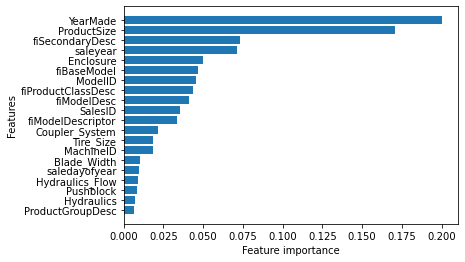

In [ ]:
plot_features(X_train.columns, ideal_model.feature_importances_)

In [ ]:
df["Enclosure"].value_counts()

OROPS                  177971
EROPS                  141769
EROPS w AC              92601
EROPS AC                   18
NO ROPS                     3
None or Unspecified         2
Name: Enclosure, dtype: int64

In [ ]:
sum(ideal_model.feature_importances_)

1.0